Default Classification - Test Accuracy: 0.5926, Precision: 0.3000, Recall: 0.1667
DEFAULT CLASSIFICATION MODEL - VALIDATION PROTOCOL

5-Fold Cross-Validation Results (Mean across folds):
  Accuracy:  0.6367
  Precision: 0.3968
  Recall:    0.2385

Full Training Set Performance:
  Accuracy:  0.7567
  Precision: 0.6765
  Recall:    0.4742

Test Set Performance:
  Accuracy:  0.5926
  Precision: 0.3000
  Recall:    0.1667
Default Regression - Test MSE: 258.0161
DEFAULT REGRESSION MODEL - VALIDATION PROTOCOL

5-Fold Cross-Validation Results (Mean across folds):
  MSE: 281.4409

Full Training Set Performance:
  MSE: 239.0442

Test Set Performance:
  MSE: 258.0161
Best activation for classification: tanh
Best activation for regression: relu
ACTIVATION FUNCTION COMPARISON (5-Fold CV Mean)

CLASSIFICATION:
Activation  Accuracy    Precision   Recall      
----------------------------------------------------------------------
relu        0.6567      0.4327      0.2734      
tanh        0.6900    

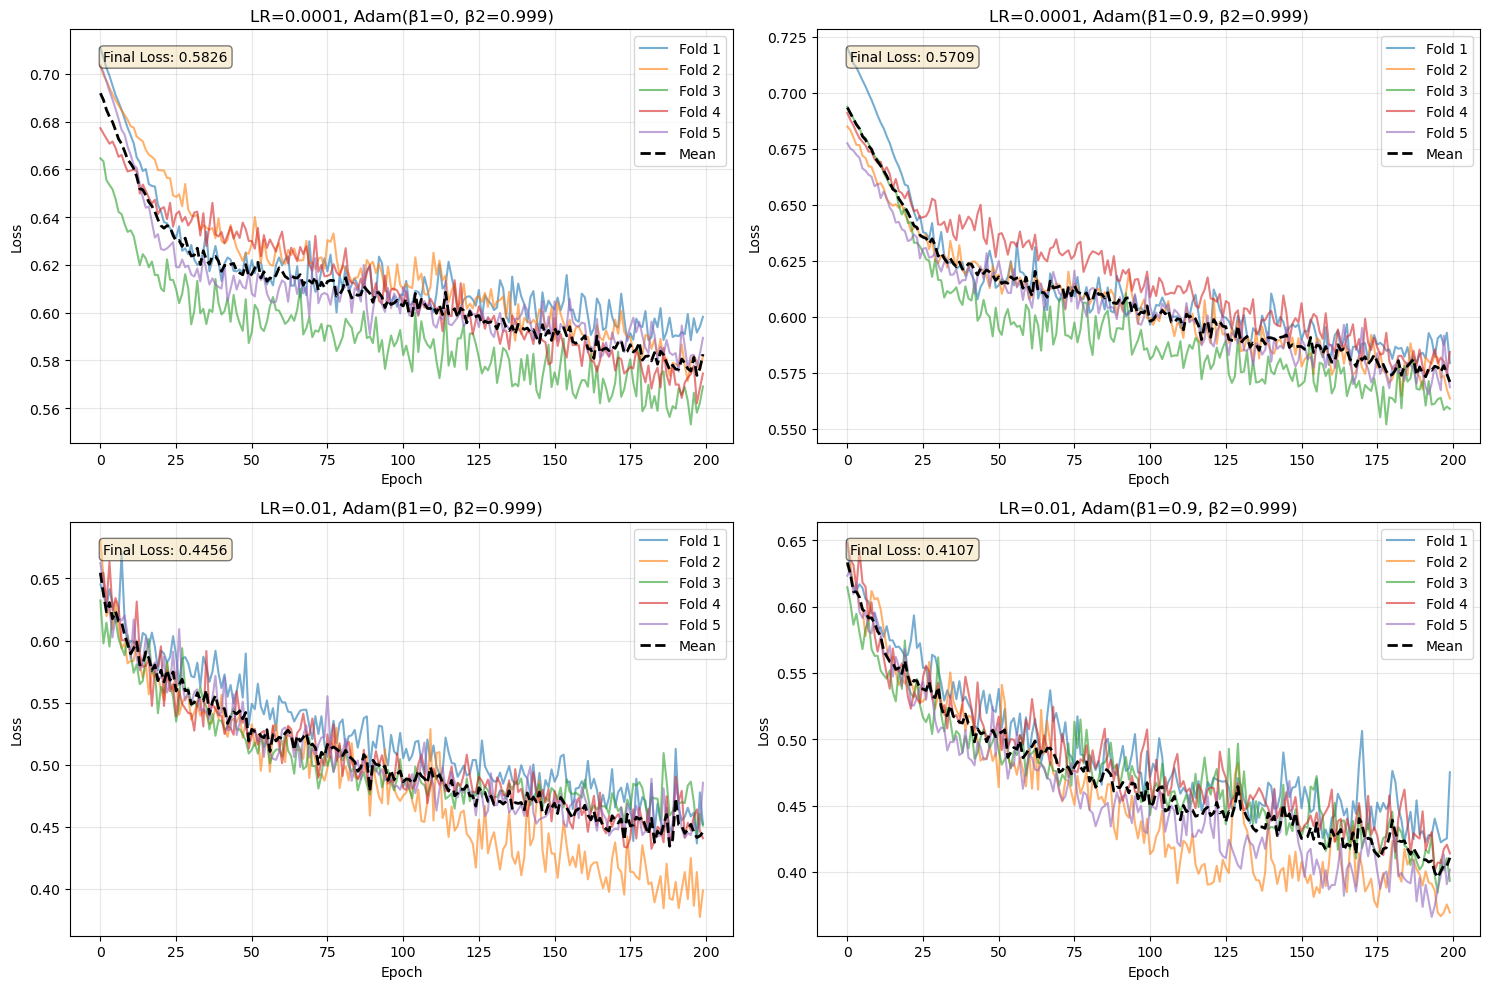

Best Classification Config: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'lr': 0.0001, 'momentum': 0, 'epochs': 200, 'batch_size': 32}
Best Regression Config: {'hidden_sizes': [64, 32], 'activation': 'relu', 'lr': 0.0001, 'momentum': 0, 'epochs': 200, 'batch_size': 32}
LEARNING RATE & MOMENTUM COMPARISON (5-Fold CV Mean)

CLASSIFICATION:
Configuration                      Accuracy    Precision   Recall      
----------------------------------------------------------------------
LR=0.0001, Adam(β1=0, β2=0.999)    0.6533      0.4462      0.0629       <-- BEST
LR=0.0001, Adam(β1=0.9, β2=0.999)  0.6400      0.2364      0.0586      
LR=0.01, Adam(β1=0, β2=0.999)      0.6467      0.4167      0.2554      
LR=0.01, Adam(β1=0.9, β2=0.999)    0.6233      0.3783      0.2445      

REGRESSION:
Configuration                      MSE         
----------------------------------------------------------------------
LR=0.0001, Adam(β1=0, β2=0.999)    281.7797     <-- BEST
LR=0.0001, Adam(β1=0.9, β2=

In [2]:
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with open('A2Q1_data.pkl', 'rb') as f:
    data_class = pickle.load(f)

with open('A2Q1_data_regression.pkl', 'rb') as f:
    data_reg = pickle.load(f)

X_class_train = np.array(data_class['X_train'], dtype=np.float64)
y_class_train = np.array(data_class['y_train'], dtype=np.float64)
X_class_test = np.array(data_class['X_test'], dtype=np.float64)
y_class_test = np.array(data_class['y_test'], dtype=np.float64)

X_reg_train = np.array(data_reg['X_train'], dtype=np.float64)
y_reg_train = np.array(data_reg['y_train'], dtype=np.float64)
X_reg_test = np.array(data_reg['X_test'], dtype=np.float64)
y_reg_test = np.array(data_reg['y_test'], dtype=np.float64)
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation='relu', task='classification'):
        super(NeuralNetwork, self).__init__()
        self.task = task
        self.activation_type = activation
        
        layers = []
        prev_size = input_size
        
        for i, hidden_size in enumerate(hidden_sizes):
            layers.append(nn.Linear(prev_size, hidden_size))
            
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'mixed':
                if i % 2 == 0:
                    layers.append(nn.ReLU())
                else:
                    layers.append(nn.Tanh())
            
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, output_size))
        
        if task == 'classification':
            layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

DEFAULT_HIDDEN_SIZES = [64, 32]
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    loss_history = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        loss_history.append(epoch_loss / len(train_loader))
    
    return loss_history

def evaluate_classification(model, X, y):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X).to(device)
        outputs = model(X_tensor).cpu().numpy()
        predictions = (outputs > 0.5).astype(int).flatten()
    
    return {
        'accuracy': accuracy_score(y, predictions),
        'precision': precision_score(y, predictions, zero_division=0),
        'recall': recall_score(y, predictions, zero_division=0),
        'predictions': predictions
    }

def evaluate_regression(model, X, y):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X).to(device)
        outputs = model(X_tensor).cpu().numpy().flatten()
    
    return {
        'mse': mean_squared_error(y, outputs),
        'predictions': outputs
    }
def cross_validate(X_train, y_train, model_params, task='classification', 
                   lr=0.01, momentum=0, epochs=100, batch_size=32, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = []
    cv_losses = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        input_size = X_train.shape[1]
        if task == 'classification':
            output_size = 1
            criterion = nn.BCELoss()
            model = NeuralNetwork(input_size, model_params['hidden_sizes'], 
                                 output_size, activation=model_params['activation'], 
                                 task='classification').to(device)
        else:
            output_size = 1
            criterion = nn.MSELoss()
            model = NeuralNetwork(input_size, model_params['hidden_sizes'], 
                                 output_size, activation=model_params['activation'], 
                                 task='regression').to(device)
        
        # Use Adam optimizer with momentum (beta1) and beta2=0.999
        # betas=(beta1, beta2) where beta1 controls momentum, beta2 controls second moment
        if momentum > 0:
            optimizer = optim.Adam(model.parameters(), lr=lr, betas=(momentum, 0.999))
        else:
            optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.0, 0.999))
        
        y_tr_tensor = torch.FloatTensor(y_tr).reshape(-1, 1)
        train_dataset = TensorDataset(torch.FloatTensor(X_tr), y_tr_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        loss_history = train_model(model, train_loader, criterion, optimizer, epochs=epochs)
        cv_losses.append(loss_history)
        
        if task == 'classification':
            metrics = evaluate_classification(model, X_val, y_val)
        else:
            metrics = evaluate_regression(model, X_val, y_val)
        
        cv_scores.append(metrics)
        
    return cv_scores, cv_losses
default_params = {
    'hidden_sizes': DEFAULT_HIDDEN_SIZES,
    'activation': 'relu',
    'lr': 0.001,
    'momentum': 0,
    'epochs': 200,
    'batch_size': 32
}

cv_scores, cv_losses = cross_validate(
    X_class_train, y_class_train, 
    model_params={'hidden_sizes': default_params['hidden_sizes'], 'activation': default_params['activation']},
    task='classification',
    lr=default_params['lr'],
    momentum=default_params['momentum'],
    epochs=default_params['epochs'],
    batch_size=default_params['batch_size']
)

mean_accuracy = np.mean([s['accuracy'] for s in cv_scores])
mean_precision = np.mean([s['precision'] for s in cv_scores])
mean_recall = np.mean([s['recall'] for s in cv_scores])

input_size = X_class_train.shape[1]
default_class_model = NeuralNetwork(
    input_size, default_params['hidden_sizes'], 1, 
    activation=default_params['activation'], task='classification'
).to(device)

criterion = nn.BCELoss()
# Adam optimizer: betas=(beta1, beta2) where beta1=momentum, beta2=0.999 (fixed)
if default_params['momentum'] > 0:
    optimizer = optim.Adam(default_class_model.parameters(), lr=default_params['lr'], 
                          betas=(default_params['momentum'], 0.999))
else:
    optimizer = optim.Adam(default_class_model.parameters(), lr=default_params['lr'],
                          betas=(0.0, 0.999))

y_class_train_tensor = torch.FloatTensor(y_class_train).reshape(-1, 1)
train_dataset = TensorDataset(torch.FloatTensor(X_class_train), y_class_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=default_params['batch_size'], shuffle=True)

default_class_loss = train_model(default_class_model, train_loader, criterion, optimizer, 
                                 epochs=default_params['epochs'])

train_metrics = evaluate_classification(default_class_model, X_class_train, y_class_train)
test_metrics = evaluate_classification(default_class_model, X_class_test, y_class_test)

default_class_results = {
    'cv_mean': {'accuracy': mean_accuracy, 'precision': mean_precision, 'recall': mean_recall},
    'train': train_metrics,
    'test': test_metrics,
    'cv_losses': cv_losses,
    'train_loss': default_class_loss

}

print(f"Default Classification - Test Accuracy: {test_metrics['accuracy']:.4f}, Precision: {test_metrics['precision']:.4f}, Recall: {test_metrics['recall']:.4f}")
print("=" * 70)
print("DEFAULT CLASSIFICATION MODEL - VALIDATION PROTOCOL")
print("=" * 70)
print("\n5-Fold Cross-Validation Results (Mean across folds):")
print(f"  Accuracy:  {default_class_results['cv_mean']['accuracy']:.4f}")
print(f"  Precision: {default_class_results['cv_mean']['precision']:.4f}")
print(f"  Recall:    {default_class_results['cv_mean']['recall']:.4f}")

print("\nFull Training Set Performance:")
print(f"  Accuracy:  {default_class_results['train']['accuracy']:.4f}")
print(f"  Precision: {default_class_results['train']['precision']:.4f}")
print(f"  Recall:    {default_class_results['train']['recall']:.4f}")

print("\nTest Set Performance:")
print(f"  Accuracy:  {default_class_results['test']['accuracy']:.4f}")
print(f"  Precision: {default_class_results['test']['precision']:.4f}")
print(f"  Recall:    {default_class_results['test']['recall']:.4f}")
cv_scores_reg, cv_losses_reg = cross_validate(
    X_reg_train, y_reg_train,
    model_params={'hidden_sizes': default_params['hidden_sizes'], 'activation': default_params['activation']},
    task='regression',
    lr=default_params['lr'],
    momentum=default_params['momentum'],
    epochs=default_params['epochs'],
    batch_size=default_params['batch_size']
)

mean_mse = np.mean([s['mse'] for s in cv_scores_reg])

input_size = X_reg_train.shape[1]
default_reg_model = NeuralNetwork(
    input_size, default_params['hidden_sizes'], 1,
    activation=default_params['activation'], task='regression'
).to(device)

criterion = nn.MSELoss()
# Adam optimizer: betas=(beta1, beta2) where beta1=momentum, beta2=0.999 (fixed)
if default_params['momentum'] > 0:
    optimizer = optim.Adam(default_reg_model.parameters(), lr=default_params['lr'], 
                          betas=(default_params['momentum'], 0.999))
else:
    optimizer = optim.Adam(default_reg_model.parameters(), lr=default_params['lr'],
                          betas=(0.0, 0.999))

y_reg_train_tensor = torch.FloatTensor(y_reg_train).reshape(-1, 1)
train_dataset = TensorDataset(torch.FloatTensor(X_reg_train), y_reg_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=default_params['batch_size'], shuffle=True)

default_reg_loss = train_model(default_reg_model, train_loader, criterion, optimizer,
                               epochs=default_params['epochs'])

train_metrics_reg = evaluate_regression(default_reg_model, X_reg_train, y_reg_train)
test_metrics_reg = evaluate_regression(default_reg_model, X_reg_test, y_reg_test)

default_reg_results = {
    'cv_mean': {'mse': mean_mse},
    'train': train_metrics_reg,
    'test': test_metrics_reg,
    'cv_losses': cv_losses_reg,
    'train_loss': default_reg_loss

}

print(f"Default Regression - Test MSE: {test_metrics_reg['mse']:.4f}")
print("=" * 70)
print("DEFAULT REGRESSION MODEL - VALIDATION PROTOCOL")
print("=" * 70)
print("\n5-Fold Cross-Validation Results (Mean across folds):")
print(f"  MSE: {default_reg_results['cv_mean']['mse']:.4f}")

print("\nFull Training Set Performance:")
print(f"  MSE: {default_reg_results['train']['mse']:.4f}")

print("\nTest Set Performance:")
print(f"  MSE: {default_reg_results['test']['mse']:.4f}")
activations = ['relu', 'tanh', 'mixed']
activation_results = {'classification': {}, 'regression': {}}

for activation in activations:
    cv_scores_act, _ = cross_validate(
        X_class_train, y_class_train,
        model_params={'hidden_sizes': default_params['hidden_sizes'], 'activation': activation},
        task='classification',
        lr=default_params['lr'],
        momentum=default_params['momentum'],
        epochs=default_params['epochs'],
        batch_size=default_params['batch_size']
    )
    
    activation_results['classification'][activation] = {
        'accuracy': np.mean([s['accuracy'] for s in cv_scores_act]),
        'precision': np.mean([s['precision'] for s in cv_scores_act]),
        'recall': np.mean([s['recall'] for s in cv_scores_act])
    }
    
    cv_scores_reg_act, _ = cross_validate(
        X_reg_train, y_reg_train,
        model_params={'hidden_sizes': default_params['hidden_sizes'], 'activation': activation},
        task='regression',
        lr=default_params['lr'],
        momentum=default_params['momentum'],
        epochs=default_params['epochs'],
        batch_size=default_params['batch_size']
    )
    
    activation_results['regression'][activation] = {
        'mse': np.mean([s['mse'] for s in cv_scores_reg_act])
    }

best_class_act = max(activations, key=lambda x: activation_results['classification'][x]['accuracy'])
best_reg_act = min(activations, key=lambda x: activation_results['regression'][x]['mse'])

print(f"Best activation for classification: {best_class_act}")
print(f"Best activation for regression: {best_reg_act}")
print("=" * 70)
print("ACTIVATION FUNCTION COMPARISON (5-Fold CV Mean)")
print("=" * 70)

print("\nCLASSIFICATION:")
print(f"{'Activation':<12}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}")
print("-" * 70)
for act in activations:
    res = activation_results['classification'][act]
    marker = " <-- BEST" if act == best_class_act else ""
    print(f"{act:<12}{res['accuracy']:<12.4f}{res['precision']:<12.4f}{res['recall']:<12.4f}{marker}")

print("\nREGRESSION:")
print(f"{'Activation':<12}{'MSE':<12}")
print("-" * 70)
for act in activations:
    res = activation_results['regression'][act]
    marker = " <-- BEST" if act == best_reg_act else ""
    print(f"{act:<12}{res['mse']:<12.4f}{marker}")
lr_configs = [
    {'lr': 0.0001, 'momentum': 0, 'name': 'LR=0.0001, Adam(β1=0, β2=0.999)'},
    {'lr': 0.0001, 'momentum': 0.9, 'name': 'LR=0.0001, Adam(β1=0.9, β2=0.999)'},
    {'lr': 0.01, 'momentum': 0, 'name': 'LR=0.01, Adam(β1=0, β2=0.999)'},
    {'lr': 0.01, 'momentum': 0.9, 'name': 'LR=0.01, Adam(β1=0.9, β2=0.999)'},
]

lr_results = {'classification': {}, 'regression': {}}
lr_losses = {}

for config in lr_configs:
    config_name = config['name']
    
    cv_scores, cv_losses = cross_validate(
        X_class_train, y_class_train,
        model_params={'hidden_sizes': default_params['hidden_sizes'], 'activation': 'relu'},
        task='classification',
        lr=config['lr'],
        momentum=config['momentum'],
        epochs=default_params['epochs'],
        batch_size=default_params['batch_size']
    )
    
    lr_results['classification'][config_name] = {
        'accuracy': np.mean([s['accuracy'] for s in cv_scores]),
        'precision': np.mean([s['precision'] for s in cv_scores]),
        'recall': np.mean([s['recall'] for s in cv_scores])
    }
    lr_losses[config_name] = cv_losses
    
    if config['lr'] >= 0.01 and config['momentum'] == 0:
        lr_results['regression'][config_name] = {'mse': float('inf')}
    else:
        try:
            cv_scores_reg, _ = cross_validate(
                X_reg_train, y_reg_train,
                model_params={'hidden_sizes': default_params['hidden_sizes'], 'activation': 'relu'},
                task='regression',
                lr=config['lr'],
                momentum=config['momentum'],
                epochs=default_params['epochs'],
                batch_size=default_params['batch_size']
            )
            
            lr_results['regression'][config_name] = {'mse': np.mean([s['mse'] for s in cv_scores_reg])}
        except:
            lr_results['regression'][config_name] = {'mse': float('inf')}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, config in enumerate(lr_configs):
    config_name = config['name']
    ax = axes[idx]
    
    for fold_idx, loss_curve in enumerate(lr_losses[config_name]):
        ax.plot(loss_curve, alpha=0.6, label=f'Fold {fold_idx+1}')
    
    mean_loss = np.mean(lr_losses[config_name], axis=0)
    ax.plot(mean_loss, 'k--', linewidth=2, label='Mean')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'{config_name}')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    final_mean_loss = mean_loss[-1]
    ax.text(0.05, 0.95, f'Final Loss: {final_mean_loss:.4f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('lr_momentum_loss_curves.png', dpi=150, bbox_inches='tight')
plt.show()
best_class_activation = best_class_act
best_reg_activation = best_reg_act

best_class_config = max(lr_configs, key=lambda c: lr_results['classification'][c['name']]['accuracy'])
best_reg_config = min(lr_configs, key=lambda c: lr_results['regression'][c['name']]['mse'])

best_class_params = {
    'hidden_sizes': DEFAULT_HIDDEN_SIZES,
    'activation': best_class_activation,
    'lr': best_class_config['lr'],
    'momentum': best_class_config['momentum'],
    'epochs': default_params['epochs'],
    'batch_size': default_params['batch_size']
}

best_reg_params = {
    'hidden_sizes': DEFAULT_HIDDEN_SIZES,
    'activation': best_reg_activation,
    'lr': best_reg_config['lr'],
    'momentum': best_reg_config['momentum'],
    'epochs': default_params['epochs'],
    'batch_size': default_params['batch_size']
}

print(f"Best Classification Config: {best_class_params}")
print(f"Best Regression Config: {best_reg_params}")
print("=" * 70)
print("LEARNING RATE & MOMENTUM COMPARISON (5-Fold CV Mean)")
print("=" * 70)

print("\nCLASSIFICATION:")
print(f"{'Configuration':<35}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}")
print("-" * 70)
for config in lr_configs:
    name = config['name']
    res = lr_results['classification'][name]
    marker = " <-- BEST" if config == best_class_config else ""
    print(f"{name:<35}{res['accuracy']:<12.4f}{res['precision']:<12.4f}{res['recall']:<12.4f}{marker}")

print("\nREGRESSION:")
print(f"{'Configuration':<35}{'MSE':<12}")
print("-" * 70)
for config in lr_configs:
    name = config['name']
    mse = lr_results['regression'][name]['mse']
    marker = " <-- BEST" if config == best_reg_config else ""
    if mse == float('inf'):
        print(f"{name:<35}{'UNSTABLE':<12}{marker}")
    else:
        print(f"{name:<35}{mse:<12.4f}{marker}")
input_size = X_class_train.shape[1]
best_class_model = NeuralNetwork(
    input_size, best_class_params['hidden_sizes'], 1, 
    activation=best_class_params['activation'], task='classification'
).to(device)

criterion = nn.BCELoss()
# Adam optimizer: betas=(beta1, beta2) where beta1=momentum, beta2=0.999 (fixed)
if best_class_params['momentum'] > 0:
    optimizer = optim.Adam(best_class_model.parameters(), lr=best_class_params['lr'], 
                          betas=(best_class_params['momentum'], 0.999))
else:
    optimizer = optim.Adam(best_class_model.parameters(), lr=best_class_params['lr'],
                          betas=(0.0, 0.999))

y_class_train_tensor = torch.FloatTensor(y_class_train).reshape(-1, 1)
train_dataset = TensorDataset(torch.FloatTensor(X_class_train), y_class_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=best_class_params['batch_size'], shuffle=True)

best_class_loss = train_model(best_class_model, train_loader, criterion, optimizer, 
                               epochs=best_class_params['epochs'])

train_metrics_best = evaluate_classification(best_class_model, X_class_train, y_class_train)
test_metrics_best = evaluate_classification(best_class_model, X_class_test, y_class_test)

print(f"Best Classification - Test Accuracy: {test_metrics_best['accuracy']:.4f}, Precision: {test_metrics_best['precision']:.4f}, Recall: {test_metrics_best['recall']:.4f}")

acc_imp = test_metrics_best['accuracy'] - default_class_results['test']['accuracy']
prec_imp = test_metrics_best['precision'] - default_class_results['test']['precision']

rec_imp = test_metrics_best['recall'] - default_class_results['test']['recall']

print(f"Improvements - Accuracy: {acc_imp:+.4f}, Precision: {prec_imp:+.4f}, Recall: {rec_imp:+.4f}")
print("=" * 70)
print("BEST CLASSIFICATION MODEL - VALIDATION PROTOCOL")
print("=" * 70)
print(f"\nConfiguration: {best_class_params}")

print("\nFull Training Set Performance:")
print(f"  Accuracy:  {train_metrics_best['accuracy']:.4f}")
print(f"  Precision: {train_metrics_best['precision']:.4f}")
print(f"  Recall:    {train_metrics_best['recall']:.4f}")

print("\nTest Set Performance:")
print(f"  Accuracy:  {test_metrics_best['accuracy']:.4f}")
print(f"  Precision: {test_metrics_best['precision']:.4f}")
print(f"  Recall:    {test_metrics_best['recall']:.4f}")
input_size = X_reg_train.shape[1]
best_reg_model = NeuralNetwork(
    input_size, best_reg_params['hidden_sizes'], 1,
    activation=best_reg_params['activation'], task='regression'
).to(device)

criterion = nn.MSELoss()
# Adam optimizer: betas=(beta1, beta2) where beta1=momentum, beta2=0.999 (fixed)
if best_reg_params['momentum'] > 0:
    optimizer = optim.Adam(best_reg_model.parameters(), lr=best_reg_params['lr'], 
                          betas=(best_reg_params['momentum'], 0.999))
else:
    optimizer = optim.Adam(best_reg_model.parameters(), lr=best_reg_params['lr'],
                          betas=(0.0, 0.999))

y_reg_train_tensor = torch.FloatTensor(y_reg_train).reshape(-1, 1)
train_dataset = TensorDataset(torch.FloatTensor(X_reg_train), y_reg_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=best_reg_params['batch_size'], shuffle=True)

best_reg_loss = train_model(best_reg_model, train_loader, criterion, optimizer,
                            epochs=best_reg_params['epochs'])

train_metrics_reg_best = evaluate_regression(best_reg_model, X_reg_train, y_reg_train)
test_metrics_reg_best = evaluate_regression(best_reg_model, X_reg_test, y_reg_test)

print(f"Best Regression - Test MSE: {test_metrics_reg_best['mse']:.4f}")

mse_imp = default_reg_results['test']['mse'] - test_metrics_reg_best['mse']

pct_imp = (mse_imp / default_reg_results['test']['mse']) * 100

print(f"Improvement - MSE: {mse_imp:+.4f} ({pct_imp:+.2f}%)")
print("=" * 70)
print("BEST REGRESSION MODEL - VALIDATION PROTOCOL")
print("=" * 70)
print(f"\nConfiguration: {best_reg_params}")

print("\nFull Training Set Performance:")
print(f"  MSE: {train_metrics_reg_best['mse']:.4f}")

print("\nTest Set Performance:")
print(f"  MSE: {test_metrics_reg_best['mse']:.4f}")
print("=" * 70)
print("CLASSIFICATION: DEFAULT vs BEST MODEL COMPARISON")
print("=" * 70)
print()
print(f"{'Metric':<16}{'Default (Test)':<21}{'Best (Test)':<21}{'Improvement':<15}")
print("-" * 70)

# Accuracy
default_acc = default_class_results['test']['accuracy']
best_acc = test_metrics_best['accuracy']
acc_diff = best_acc - default_acc
print(f"{'Accuracy':<16}{default_acc:<21.4f}{best_acc:<21.4f}{acc_diff:+.4f}")

# Precision
default_prec = default_class_results['test']['precision']
best_prec = test_metrics_best['precision']
prec_diff = best_prec - default_prec
print(f"{'Precision':<16}{default_prec:<21.4f}{best_prec:<21.4f}{prec_diff:+.4f}")

# Recall
default_rec = default_class_results['test']['recall']
best_rec = test_metrics_best['recall']
rec_diff = best_rec - default_rec
print(f"{'Recall':<16}{default_rec:<21.4f}{best_rec:<21.4f}{rec_diff:+.4f}")
print("=" * 70)
print("REGRESSION: DEFAULT vs BEST MODEL COMPARISON")
print("=" * 70)
print()
print(f"{'Metric':<16}{'Default (Test)':<21}{'Best (Test)':<21}{'Improvement':<15}")
print("-" * 70)

# MSE
default_mse = default_reg_results['test']['mse']
best_mse = test_metrics_reg_best['mse']
mse_diff = default_mse - best_mse  # Positive means improvement
mse_pct = (mse_diff / default_mse) * 100
print(f"{'MSE':<16}{default_mse:<21.4f}{best_mse:<21.4f}{mse_diff:+.4f} ({mse_pct:+.2f}%)")